# Hawk/dove multi + adjust, hawk odds and convergence

In [2]:
import polars as pl

df = pl.read_csv("../../data/hawkdovemulti/hawkodds_c7_2024-03-01T102040_835593_model.csv")

In [3]:
total_runs = len(df)

print(f"Analyzing {total_runs} runs")

Analyzing 900 runs


## what % converged?

In [22]:
converged_df = df.filter(df["status"] == "converged")
len(converged_df)

818

In [5]:
print(f"{len(converged_df) / len(df)*100:.2f}% of runs converged")

90.89% of runs converged


In [6]:
converged_df["Step"].plot.hist()

alt.Chart(...)

### does starting hawk odds affect convergence?

In [7]:
status_by_hawkodds = df.group_by("hawk_odds", "status").count()
status_by_hawkodds

/var/folders/mb/6qm4h4yx3yqdy2bv2sjyp4z00000gp/T/ipykernel_59966/235324943.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  status_by_hawkodds = df.group_by("hawk_odds", "status").count()


hawk_odds,status,count
f64,str,u32
0.7,"""converged""",92
0.2,"""converged""",92
0.5,"""converged""",96
0.6,"""running""",8
0.9,"""running""",15
…,…,…
0.4,"""converged""",91
0.3,"""converged""",91
0.7,"""running""",8


In [8]:
import altair as alt

alt.Chart(status_by_hawkodds).mark_bar().encode(
    x='hawk_odds:N',
    y='count',
    color='status:N'
).properties(title="Simulation status (converged/running) by inital hawk odds", width=250, height=400)

alt.Chart(...)

### what about the distribution of run length by starting hawk odds?

In [9]:
alt.Chart(converged_df).mark_boxplot(size=20).encode(
    x='hawk_odds:N',
    y='Step',
).properties(
    title=alt.TitleParams(
        "Simulation run length by starting hawk odds",
        subtitle="(converged runs only)"),
    width=350, height=450)

alt.Chart(...)

In [24]:
from simulatingrisk.hawkdovemulti import analysis_utils
import importlib
importlib.reload(analysis_utils)

# calculate percentages for each risk level
# converged_df = analysis_utils.grouped_risk_totals(converged_df)


converged_df = converged_df.with_columns(
    pl.Series('pct_risk_inclined', values=converged_df.select((pl.col("total_r0") + pl.col("total_r1") + pl.col("total_r2")) / pl.col("total_agents"))),
    pl.Series('pct_risk_moderate', values=converged_df.select((pl.col("total_r3") + pl.col("total_r4") + pl.col("total_r5") + pl.col("total_r6")) / pl.col("total_agents"))),
    pl.Series('pct_risk_avoidant', values=converged_df.select((pl.col("total_r7") + pl.col("total_r8") + pl.col("total_r9")) / pl.col("total_agents")))
)
converged_df.head()

RunId,iteration,Step,hawk_odds,risk_adjustment,risk_distribution,grid_size,max_agent_points,percent_hawk,rolling_percent_hawk,status,total_agents,population_risk_category,num_agents_risk_changed,total_r0,total_r1,total_r2,total_r3,total_r4,total_r5,total_r6,total_r7,total_r8,total_r9,risk_inclined,risk_moderate,risk_avoidant,pct_risk_inclined,pct_risk_moderate,pct_risk_avoidant
i64,i64,i64,f64,str,str,i64,i64,f64,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
0,0,70,0.1,"""adopt""","""uniform""",10,1184,0.37,0.523,"""converged""",100,13,6,9,24,5,3,10,2,13,12,13,9,38,28,34,0.38,0.28,0.34
6,6,90,0.1,"""adopt""","""uniform""",10,1758,0.44,0.514,"""converged""",100,13,1,18,9,2,9,18,19,1,13,4,7,29,47,24,0.29,0.47,0.24
2,2,110,0.1,"""adopt""","""uniform""",10,2056,0.27,0.478667,"""converged""",100,13,3,1,12,12,2,10,19,10,8,11,15,25,41,34,0.25,0.41,0.34
7,7,120,0.1,"""adopt""","""uniform""",10,2261,0.47,0.560333,"""converged""",100,3,0,14,31,9,0,12,3,0,12,11,8,54,15,31,0.54,0.15,0.31
4,4,130,0.1,"""adopt""","""uniform""",10,2630,0.46,0.531667,"""converged""",100,13,3,11,4,21,14,0,15,0,17,16,2,36,29,35,0.36,0.29,0.35


In [13]:
# calculate percentages for the larger groupings
#converged_df = analysis_utils.percent_risk_buckets(converged_df)

## is there a correlation between hawk odds and percent risk inclined?

In [16]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

In [25]:
# construct our input and output and split into test/train
from sklearn.model_selection import train_test_split

# input (x value) = initial hawk odds
# NOTE: train wants not a series but a dataframe with a single series
input = converged_df[["hawk_odds"]]

# output (y value, potential correlation) = percent risk inclined
output = converged_df[["pct_risk_inclined"]]

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2)


In [26]:
# train the model
regr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [27]:
# output the best fit values
print("Intercept: \n", regr.intercept_)
print("Coefficients: \n", regr.coef_)

Intercept: 
 [0.39787349]
Coefficients: 
 [[0.02777488]]


Text(0, 0.5, 'percent risk inclined')

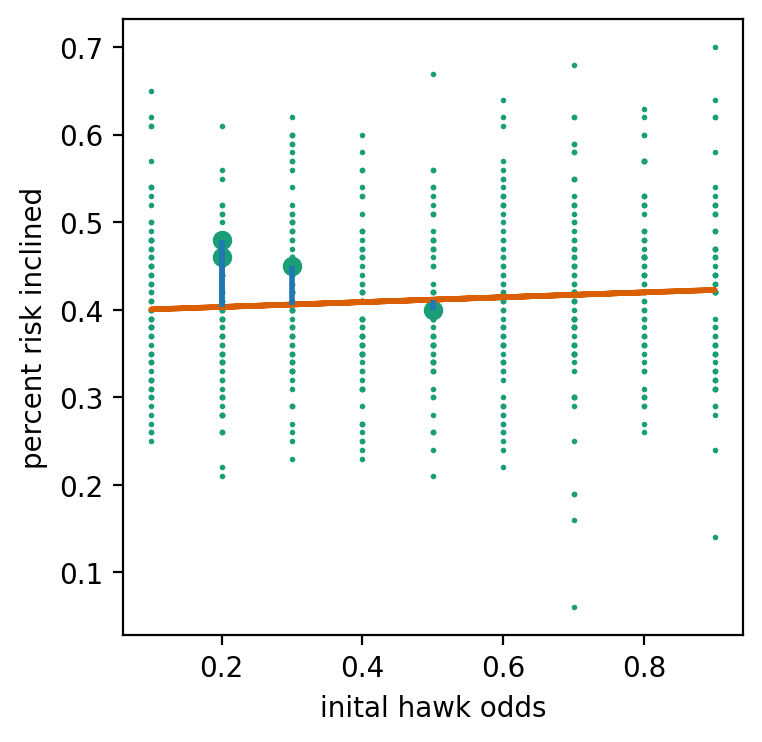

In [28]:
import matplotlib.pyplot as plt

qualitiative_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']

fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=200)
axs.scatter(X_train, y_train, s=1, color=qualitiative_colors[0])
axs.plot(X_train, regr.predict(X_train), color=qualitiative_colors[1], linewidth=2)
axs.scatter(X_train[:4], y_train[:4], color=qualitiative_colors[0])
axs.vlines(X_train[:4], regr.intercept_ + regr.coef_[0]*X_train[:4], y_train[:4], lw=2)
axs.set_xlabel('inital hawk odds')
axs.set_ylabel('percent risk inclined')

In [29]:
# make predictions based on this fit
y_pred_linear = regr.predict(X_test)

Text(0, 0.5, 'truth - model')

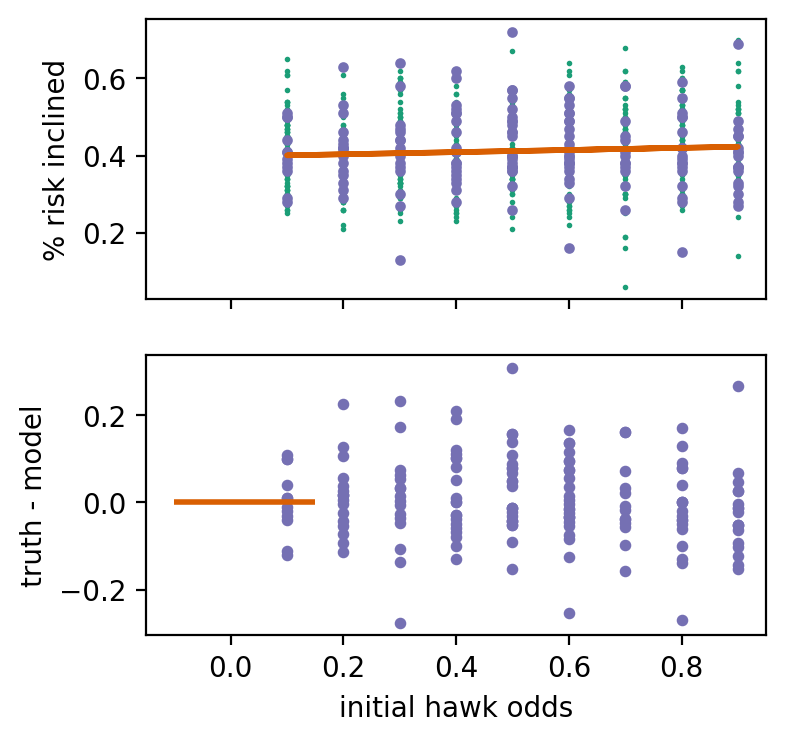

In [30]:
fig, axs = plt.subplots(figsize=(4.,4.), nrows=2, ncols=1, facecolor='white', dpi=200, sharex=True)
axs[0].scatter(X_train, y_train, s=1, color=qualitiative_colors[0])
axs[0].plot(X_test, y_pred_linear, color=qualitiative_colors[1], linewidth=2)
axs[0].scatter(X_test, y_test, color=qualitiative_colors[2], s=8)
axs[1].hlines(0, -0.1, 0.15, color=qualitiative_colors[1], linewidth=2)
axs[1].scatter(X_test, y_test.to_numpy()-y_pred_linear, color=qualitiative_colors[2], s=10)
axs[1].set_xlabel('initial hawk odds')
axs[0].set_ylabel('% risk inclined')
axs[1].set_ylabel('truth - model')

## check for linear correlations with risk moderate and risk neutral

In [31]:
# output (y value, potential correlation) = percent risk inclined
rmoderate_output = converged_df[["pct_risk_moderate"]]

X_train, X_test, rmoderate_train, rmoderate_test = train_test_split(input, rmoderate_output, test_size=0.2)

In [32]:
# fit another linear regression model
rmoderate_regr = LinearRegression()
rmoderate_regr.fit(X_train, rmoderate_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
# output the best fit values
print("Intercept: \n", rmoderate_regr.intercept_)
print("Coefficients: \n", rmoderate_regr.coef_)

Intercept: 
 [0.33433546]
Coefficients: 
 [[-0.01935048]]


Text(0, 0.5, 'percent risk moderate')

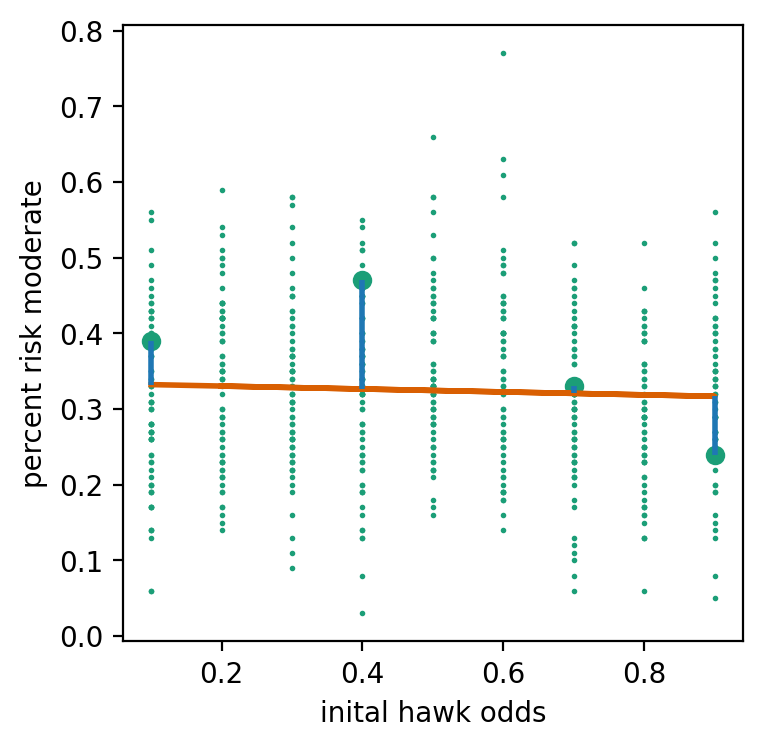

In [34]:

fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=200)
axs.scatter(X_train, rmoderate_train, s=1, color=qualitiative_colors[0])
axs.plot(X_train, rmoderate_regr.predict(X_train), color=qualitiative_colors[1], linewidth=2)
axs.scatter(X_train[:4], rmoderate_train[:4], color=qualitiative_colors[0])
axs.vlines(X_train[:4], rmoderate_regr.intercept_ + rmoderate_regr.coef_[0]*X_train[:4], rmoderate_train[:4], lw=2)
axs.set_xlabel('inital hawk odds')
axs.set_ylabel('percent risk moderate')

In [35]:
# make predictions based on this fit
rmoderate_y_pred_linear = rmoderate_regr.predict(X_test)

Text(0, 0.5, 'truth - model')

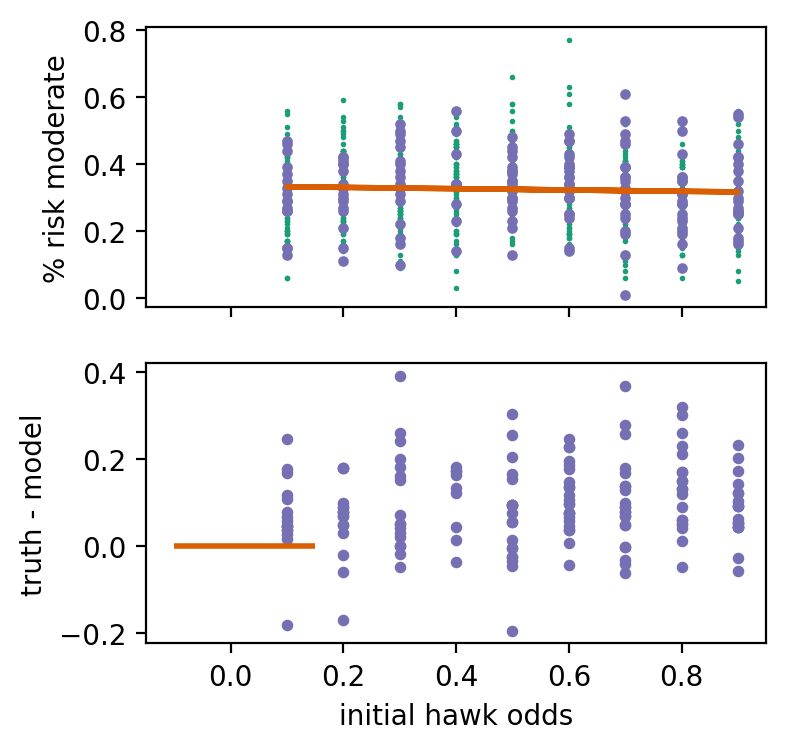

In [36]:
fig, axs = plt.subplots(figsize=(4.,4.), nrows=2, ncols=1, facecolor='white', dpi=200, sharex=True)
axs[0].scatter(X_train, rmoderate_train, s=1, color=qualitiative_colors[0])
axs[0].plot(X_test, rmoderate_y_pred_linear, color=qualitiative_colors[1], linewidth=2)
axs[0].scatter(X_test, rmoderate_test, color=qualitiative_colors[2], s=8)
axs[1].hlines(0, -0.1, 0.15, color=qualitiative_colors[1], linewidth=2)
axs[1].scatter(X_test, y_test.to_numpy()-rmoderate_y_pred_linear, color=qualitiative_colors[2], s=10)
axs[1].set_xlabel('initial hawk odds')
axs[0].set_ylabel('% risk moderate')
axs[1].set_ylabel('truth - model')

In [39]:
ravoidant_output = converged_df[["pct_risk_avoidant"]]

X_train, X_test, ravoidant_train, ravoidant_test = train_test_split(input, ravoidant_output, test_size=0.2)

In [40]:
# fit another linear regression model
ravoidant_regr = LinearRegression()
ravoidant_regr.fit(X_train, ravoidant_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [41]:
# output the best fit values
print("Intercept: \n", ravoidant_regr.intercept_)
print("Coefficients: \n", ravoidant_regr.coef_)

Intercept: 
 [0.26700041]
Coefficients: 
 [[-0.00755293]]


Text(0, 0.5, 'percent risk avoidant')

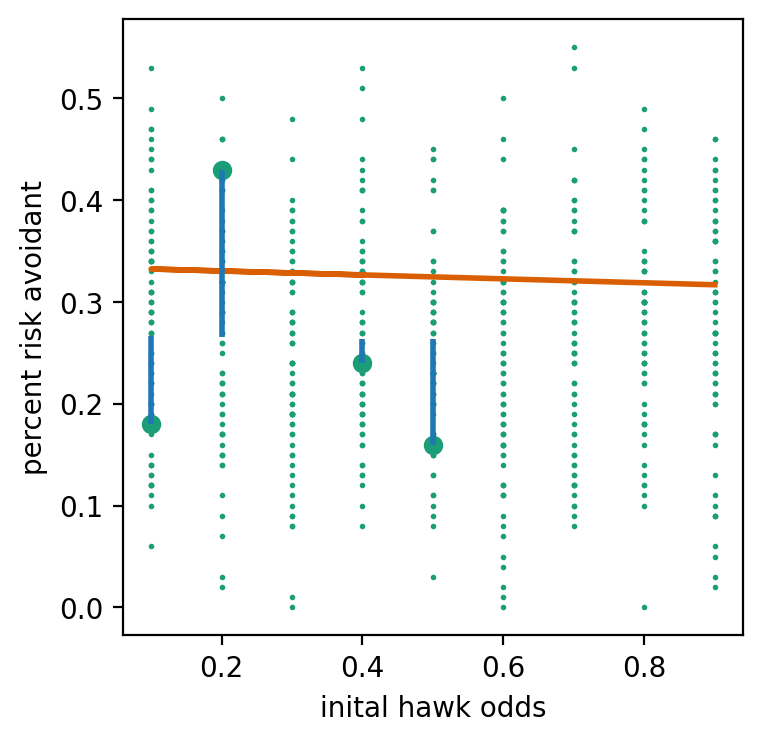

In [42]:
fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=200)
axs.scatter(X_train, ravoidant_train, s=1, color=qualitiative_colors[0])
axs.plot(X_train, rmoderate_regr.predict(X_train), color=qualitiative_colors[1], linewidth=2)
axs.scatter(X_train[:4], ravoidant_train[:4], color=qualitiative_colors[0])
axs.vlines(X_train[:4], ravoidant_regr.intercept_ + ravoidant_regr.coef_[0]*X_train[:4], ravoidant_train[:4], lw=2)
axs.set_xlabel('inital hawk odds')
axs.set_ylabel('percent risk avoidant')

### how do the distributions compare?

In [43]:
boxplot_risk_inclined = alt.Chart(converged_df).mark_boxplot(size=20, color="#e49444").encode(
    x='hawk_odds:N',
    y='pct_risk_inclined',
).properties(
    title="% risk inclined by starting hawk odds",
    width=350, height=450)

boxplot_risk_moderate = alt.Chart(converged_df).mark_boxplot(size=20, color="#d1615d").encode(
    x='hawk_odds:N',
    y='pct_risk_moderate',
).properties(
    title="% risk moderate by starting hawk odds",
     width=350, height=450
)


boxplot_risk_avoidant = alt.Chart(converged_df).mark_boxplot(size=20).encode(
    x='hawk_odds:N',
    y='pct_risk_avoidant',
).properties(
    title="% risk avoidant by starting hawk odds",
     width=350, height=450
)
(boxplot_risk_inclined | boxplot_risk_moderate | boxplot_risk_avoidant).resolve_scale(y='shared')

alt.HConcatChart(...)

In [49]:
# can we melt to put in a single boxplot with colors?

# rename for readability, then go from wide to long so we can plot side by side
melted_df = converged_df \
     .rename({"pct_risk_inclined": "% risk inclined", "pct_risk_moderate": "% risk moderate", "pct_risk_avoidant": "% risk avoidant"}) \
     .unpivot(index=['hawk_odds'], on=['% risk inclined', '% risk moderate', '% risk avoidant'])
melted_df



hawk_odds,variable,value
f64,str,f64
0.1,"""% risk inclined""",0.38
0.1,"""% risk inclined""",0.29
0.1,"""% risk inclined""",0.25
0.1,"""% risk inclined""",0.54
0.1,"""% risk inclined""",0.36
…,…,…
0.9,"""% risk avoidant""",0.22
0.9,"""% risk avoidant""",0.11
0.9,"""% risk avoidant""",0.32


In [50]:

alt.Chart(melted_df).mark_boxplot().encode(
    x=alt.X('hawk_odds:N', title='initial hawk odds'),
    y=alt.Y('value', title='percent of the population'),
    color=alt.Color('variable'),
    xOffset=alt.XOffset('variable')
)

alt.Chart(...)

### population categories by initial hawk odds

In [51]:

hawkodds01_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.1))
).properties(title="hawk odds 0.1")
hawkodds02_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.2))
).properties(title="hawk odds 0.2")
hawkodds03_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.3))
).properties(title="hawk odds 0.3")

hawkodds04_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.4))
).properties(title="hawk odds 0.4")
hawkodds05_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.5))
).properties(title="hawk odds 0.5")
hawkodds06_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.6))
).properties(title="hawk odds 0.6")


hawkodds07_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.7))
).properties(title="hawk odds 0.7")
hawkodds08_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.8))
).properties(title="hawk odds 0.8")
hawkodds09_chart = analysis_utils.graph_population_risk_category(
    analysis_utils.groupby_population_risk_category(converged_df.filter(pl.col("hawk_odds") == 0.9))
).properties(title="hawk odds 0.9")


((hawkodds01_chart | hawkodds02_chart | hawkodds03_chart) &
 (hawkodds04_chart | hawkodds05_chart | hawkodds06_chart) &
 (hawkodds07_chart | hawkodds08_chart | hawkodds09_chart))\
.properties(title=alt.TitleParams("Population risk category by run over hawk odds", subtitle="(converged runs only)", anchor="middle")
           ).resolve_scale(y='shared')


/Users/rkoeser/workarea/env/simrisk/lib/python3.12/site-packages/simulatingrisk/hawkdovemulti/analysis_utils.py:28: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  values=poprisk_grouped["risk_category"].map_elements(RiskState.category),


alt.VConcatChart(...)